In [1]:
import gated_bert
import transformers
from torch import nn, optim
import torch.nn.functional as F
import torch
import numpy as np
import spacy
import matplotlib.pyplot as plt

I0106 20:11:02.366476 139638260496192 file_utils.py:39] PyTorch version 1.1.0 available.


In [2]:
class HeadPruningViz(object):
    """
        a) Prune attention heads of BertBase for each token of a sentence
        b) Visualization for critical attention path
    """
    
    def __init__(self, weights='bert-base-uncased', cuda=False):
        self.tokenizer = transformers.BertTokenizer.from_pretrained(weights)
        self.CE_loss = nn.CrossEntropyLoss()

        self.to_cuda = lambda x: x.to('cuda') if cuda else x
        self.model = self.to_cuda(gated_bert.BertForMaskedLM.from_pretrained(weights))

    def encode_ids(self, text):
        input_ids = torch.tensor([self.tokenizer.encode(text, add_special_tokens=True)])
        for index_target in range(1, len(input_ids[0]) - 1):
            if self.target_ids[0, index_target] != 100:
                input_ids[0, index_target] = 103
                yield index_target, input_ids 
                input_ids[0, index_target] = self.target_ids[0, index_target]
        
    def retrieve_gates(self):
        gates = list(filter(lambda p: p.requires_grad, self.model.parameters()))
        return np.array([ e.cpu().detach().numpy().flatten() for e in gates ])

    def retrieve_attention(self):
        return np.array([ [ x for x in e.cpu().detach().numpy() ]
                         for e in self.model.retrieve_attention_prob() ])

    def loss_cross_entropy(self, prediction_scores, index_target):
        return self.CE_loss(prediction_scores[0][index_target].view(-1, prediction_scores.shape[2]),
                            self.target_ids[0][index_target].view(-1))

    def norm_l1(self):
        return sum([ param.norm(p=1) for param in self.model.parameters() if param.requires_grad ])

    def clip_value(self, min=0., max=10.):
        [ param.data.clamp_(min=min, max=max) for param in self.model.parameters() if param.requires_grad ]

    def init_gates(self, index_target):
        for param in self.model.parameters():
            param.requires_grad = False
        self.model.init_head_gates(index_target)
        return optim.Adam(filter(lambda p: p.requires_grad, self.model.parameters()), lr=self.lr)

    def prune_heads(self, index_target, input_ids):
        print ("\n{:<10}{:<10}{:<10}{:<10}".format("token", "Epochs", "CE loss", "Gates remaining"))
        for e in range(self.epochs):
            self.optimizer.zero_grad()
            prediction_scores = self.model(input_ids)
            l = self.loss_cross_entropy(prediction_scores, index_target)
            n = self.norm_l1()
            l += (self.sigma * n)
            l.backward()
            self.optimizer.step()
            self.clip_value()
            print ("{:<10}{:<10}{:<10}{:<10}".format(self.tokens[index_target], e,
                                                     round(l.item(), 4) , round(n.item(), 4)))
        return self.retrieve_gates(), self.retrieve_attention()

    def prune_text(self, text, lr=0.1, sigma=0.1, epochs=100):
        self.lr = lr
        self.sigma = sigma
        self.epochs = epochs

        self.target_ids = self.to_cuda(torch.tensor([self.tokenizer.encode(text, add_special_tokens=True)]))
        self.tokens = [ self.tokenizer._convert_id_to_token(t) for t in self.target_ids[0].numpy() ]
        gen_input = self.encode_ids(text)

        sentence = []
        for index_target, input_ids in gen_input:
            self.optimizer = self.init_gates(index_target)
            sentence += [(self.prune_heads(index_target, self.to_cuda(input_ids)))]
        return sentence, self.tokens

    def viz_text(self, sentence, tokens, dot=False):
        mat = np.array([ att.sum(1) for _, att in sentence ]) 
        mat = mat.transpose(1, 0, 2)
        if dot:
            mat = mat[:,:,1:-1]
        else:
            mat = mat[:,:-1,1:-2]

        lay_sum = []
        for layer in range(12):
            if mat[layer].sum():
                lay_sum += [ mat[layer].sum() ]
                mat[layer] /= mat[layer].max()
                   
        fig, ax = plt.subplots(figsize = (25, 15))

        size_line = mat.shape[1]
        for layer in range(len(mat)):
            dot = lay_sum[layer] * 10
            ax.scatter(layer * 1.2 + .5, 0, alpha=1, s=dot, c="royalblue", label="Unnormalized mean layer")
            for token_a in range(size_line):
                dot = mat[layer, token_a].sum() * 100
                ax.scatter((layer + 1) * 1.2 - .2, size_line - token_a, alpha=1, s=dot, c="red", label="Emitted att.")
                dot = mat[layer, :, token_a].sum() * 100
                ax.scatter(layer * 1.2, size_line - token_a, alpha=1, s=dot, c="black", label="Received att.")
                for token_b in range(size_line):
                    alpha = mat[layer, token_a, token_b]
                    ax.plot([layer * 1.2 + 1, layer * 1.2], [size_line - token_a, size_line - token_b],
                            'ro-', alpha=alpha, markersize=0, color="royalblue", label="Att. value")

        for i in range(size_line):
            plt.text(len(mat) * 1.2 + .5, size_line - i, tokens[i+1], fontsize=20)

        for layer in range(len(mat)):
            plt.text(layer * 1.2 + .4, -1, str(layer+1), fontsize=20)

        ax.scatter(0, size_line+.5, alpha=0)

        handles, labels = plt.gca().get_legend_handles_labels()
        newLabels, newHandles = [], []
        for handle, label in zip(handles, labels):
            if label not in newLabels:
                newLabels.append(label)
                newHandles.append(handle)

        lgd = plt.legend(newHandles, newLabels, loc="upper center", prop={'size': 20}, ncol=4)
        for legend_handle in lgd.legendHandles:
            legend_handle._sizes = [100]
            legend_handle.set_alpha(1)

        fig.patch.set_visible(False)
        ax.axis('off')

        plt.show()

In [3]:
## Init class
viz = HeadPruningViz()

I0106 20:11:08.046222 139638260496192 tokenization_utils.py:373] loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /home/bertrand/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
I0106 20:11:10.458948 139638260496192 configuration_utils.py:152] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /home/bertrand/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.bf3b9ea126d8c0001ee8a1e8b92229871d06d36d8808208cc2449280da87785c
I0106 20:11:10.462864 139638260496192 configuration_utils.py:169] Model config {
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": 

In [4]:
# Hyperparemeters choice
lr = 0.1
sigma = 0.1
epochs = 100

# Input text
text = "Hundreds of people have been evacuated from small villages to the south and south-west of Sydney."

# Prune heads each token at a time
# Return attention and tokenized sentence
prune_sentence, tokens = viz.prune_text(text, lr, sigma, epochs)


token     Epochs    CE loss   Gates remaining
hundreds  0         15.3195   144.0     
hundreds  1         13.8825   129.8     
hundreds  2         12.4392   115.5993  
hundreds  3         10.9871   101.3911  
hundreds  4         9.522     87.0997   
hundreds  5         8.0386    72.7493   
hundreds  6         6.5329    58.3743   
hundreds  7         5.0025    43.9843   
hundreds  8         3.4524    29.5814   
hundreds  9         5.0911    15.1839   
hundreds  10        1.6552    6.7071    
hundreds  11        1.3794    6.8611    
hundreds  12        1.4116    7.8872    
hundreds  13        1.4535    8.7713    
hundreds  14        1.4984    9.452     
hundreds  15        1.5363    9.9283    
hundreds  16        1.5551    10.1611   
hundreds  17        1.5596    10.2471   
hundreds  18        1.5538    10.2246   
hundreds  19        1.5482    10.1713   
hundreds  20        1.5395    10.0656   
hundreds  21        1.5242    9.8978    
hundreds  22        1.5032    9.678     
hundreds  

of        98        0.2519    2.3697    
of        99        0.2513    2.3594    

token     Epochs    CE loss   Gates remaining
people    0         14.8862   144.0     
people    1         13.4223   129.6001  
people    2         11.9616   115.2028  
people    3         10.5062   100.8125  
people    4         9.061     86.4386   
people    5         7.6352    72.1054   
people    6         6.2389    57.8855   
people    7         4.8503    43.9354   
people    8         3.3805    30.3216   
people    9         9.1917    16.8942   
people    10        7.9611    4.4214    
people    11        7.4476    2.3591    
people    12        7.2954    1.9617    
people    13        7.2498    1.8624    
people    14        7.1475    1.902     
people    15        7.0793    2.0971    
people    16        6.9688    2.4293    
people    17        6.8834    2.7766    
people    18        6.7933    3.2463    
people    19        6.7077    3.7278    
people    20        6.6281    4.2202    
people    

have      96        0.6982    4.4502    
have      97        0.6982    4.4558    
have      98        0.6999    4.489     
have      99        0.6969    4.4516    

token     Epochs    CE loss   Gates remaining
been      0         14.4053   144.0     
been      1         12.9655   129.6001  
been      2         11.5261   115.2001  
been      3         10.0871   100.8004  
been      4         8.6491    86.401    
been      5         7.2129    72.0024   
been      6         5.7801    57.6056   
been      7         4.3476    43.2128   
been      8         2.8902    28.8222   
been      9         9.9673    14.4432   
been      10        8.5853    4.2088    
been      11        7.815     3.9595    
been      12        3.973     5.3886    
been      13        0.9811    8.1483    
been      14        1.1111    10.896    
been      15        1.3541    13.1228   
been      16        1.5385    14.8861   
been      17        1.6793    16.2863   
been      18        1.7871    17.382    
been      

evacuated 94        1.7515    13.6845   
evacuated 95        1.7351    13.5719   
evacuated 96        1.7198    13.4508   
evacuated 97        1.7059    13.3555   
evacuated 98        1.692     13.2444   
evacuated 99        1.6772    13.1007   

token     Epochs    CE loss   Gates remaining
from      0         16.5908   144.0     
from      1         15.0565   130.8     
from      2         13.4914   117.6266  
from      3         11.8912   104.4772  
from      4         10.2599   91.3079   
from      5         8.625     78.1014   
from      6         7.0393    64.8098   
from      7         5.5532    51.3897   
from      8         4.2019    37.9212   
from      9         3.0147    24.6424   
from      10        9.9173    12.8437   
from      11        3.2152    12.5745   
from      12        1.9355    14.1929   
from      13        1.9314    15.7556   
from      14        1.9786    17.1042   
from      15        2.036     18.224    
from      16        2.0957    19.1675   
from      

small     92        1.5282    12.4155   
small     93        1.5158    12.2434   
small     94        1.4955    12.1034   
small     95        1.4763    12.0166   
small     96        1.4592    11.8885   
small     97        1.4408    11.7955   
small     98        1.4212    11.6223   
small     99        1.4014    11.4264   

token     Epochs    CE loss   Gates remaining
villages  0         17.2479   144.0     
villages  1         15.7      130.2001  
villages  2         14.1541   116.4044  
villages  3         12.6167   102.6185  
villages  4         11.0979   88.8568   
villages  5         9.6155    75.1588   
villages  6         8.1989    61.6304   
villages  7         6.8985    48.4229   
villages  8         5.9792    35.7137   
villages  9         5.5681    25.9253   
villages  10        4.1396    20.0682   
villages  11        3.8085    19.9754   
villages  12        3.6823    21.0912   
villages  13        3.6646    22.4332   
villages  14        3.6842    23.6156   
villages  

to        90        0.2218    1.8038    
to        91        0.2209    1.7804    
to        92        0.2219    1.782     
to        93        0.221     1.762     
to        94        0.2211    1.7734    
to        95        0.2207    1.7779    
to        96        0.2216    1.7923    
to        97        0.2205    1.7751    
to        98        0.2206    1.7753    
to        99        0.2207    1.7844    

token     Epochs    CE loss   Gates remaining
the       0         14.4015   144.0     
the       1         12.9614   129.6001  
the       2         11.5212   115.2001  
the       3         10.0812   100.8002  
the       4         8.6412    86.4002   
the       5         7.2014    72.0004   
the       6         5.7621    57.6007   
the       7         4.324     43.2015   
the       8         2.9066    28.8038   
the       9         4.6324    14.4914   
the       10        3.8799    2.6644    
the       11        2.7144    1.0894    
the       12        4.2231    1.2242    
the       

south     88        1.1428    8.3848    
south     89        1.1406    8.3607    
south     90        1.139     8.3355    
south     91        1.1375    8.323     
south     92        1.1373    8.3238    
south     93        1.1374    8.3408    
south     94        1.1357    8.3297    
south     95        1.1353    8.3243    
south     96        1.1348    8.304     
south     97        1.1343    8.2686    
south     98        1.1343    8.2695    
south     99        1.1336    8.2602    

token     Epochs    CE loss   Gates remaining
and       0         14.4672   144.0     
and       1         13.0372   129.6001  
and       2         11.6104   115.203   
and       3         10.1891   100.8146  
and       4         8.7766    86.449    
and       5         7.3757    72.1423   
and       6         5.9818    57.9606   
and       7         4.5848    43.9492   
and       8         3.1723    30.0872   
and       9         4.8818    16.3036   
and       10        0.741     7.363     
and       

south     86        0.8391    6.3186    
south     87        0.8369    6.3001    
south     88        0.8353    6.2842    
south     89        0.834     6.2722    
south     90        0.8353    6.3024    
south     91        0.8335    6.2776    
south     92        0.8321    6.2564    
south     93        0.8305    6.2333    
south     94        0.8308    6.2429    
south     95        0.8301    6.2266    
south     96        0.8285    6.1974    
south     97        0.8294    6.21      
south     98        0.8293    6.2157    
south     99        0.8273    6.1885    

token     Epochs    CE loss   Gates remaining
-         0         14.4027   144.0     
-         1         12.9624   129.6001  
-         2         11.5222   115.2001  
-         3         10.0823   100.8002  
-         4         8.643     86.4006   
-         5         7.2047    72.0013   
-         6         5.7683    57.6031   
-         7         4.3398    43.2076   
-         8         3.0064    28.8273   
-         

west      84        0.9878    7.8826    
west      85        0.988     7.8884    
west      86        0.9863    7.8597    
west      87        0.9847    7.8485    
west      88        0.9845    7.847     
west      89        0.9823    7.8041    
west      90        0.9825    7.795     
west      91        0.9834    7.795     
west      92        0.9815    7.7426    
west      93        0.9805    7.7021    
west      94        0.9797    7.6762    
west      95        0.9807    7.6939    
west      96        0.9803    7.6775    
west      97        0.9778    7.6335    
west      98        0.9789    7.6522    
west      99        0.9776    7.6372    

token     Epochs    CE loss   Gates remaining
of        0         14.4062   144.0     
of        1         12.9666   129.6001  
of        2         11.5272   115.2001  
of        3         10.088    100.8003  
of        4         8.6495    86.4007   
of        5         7.2126    72.0015   
of        6         5.7801    57.604    
of        

sydney    82        3.4102    20.652    
sydney    83        3.3722    20.6253   
sydney    84        3.3328    20.5868   
sydney    85        3.2909    20.5329   
sydney    86        3.2465    20.4501   
sydney    87        3.2017    20.4058   
sydney    88        3.1585    20.4194   
sydney    89        3.1163    20.4651   
sydney    90        3.0776    20.6053   
sydney    91        3.0467    20.7766   
sydney    92        3.0233    20.91     
sydney    93        2.9992    20.9821   
sydney    94        2.9776    21.0121   
sydney    95        2.9614    21.0399   
sydney    96        2.9432    20.9897   
sydney    97        2.9225    20.8696   
sydney    98        2.9072    20.7766   
sydney    99        2.8872    20.5891   

token     Epochs    CE loss   Gates remaining
.         0         14.4311   144.0     
.         1         12.9931   129.6001  
.         2         11.555    115.2     
.         3         10.1164   100.7999  
.         4         8.6773    86.3995   
.         

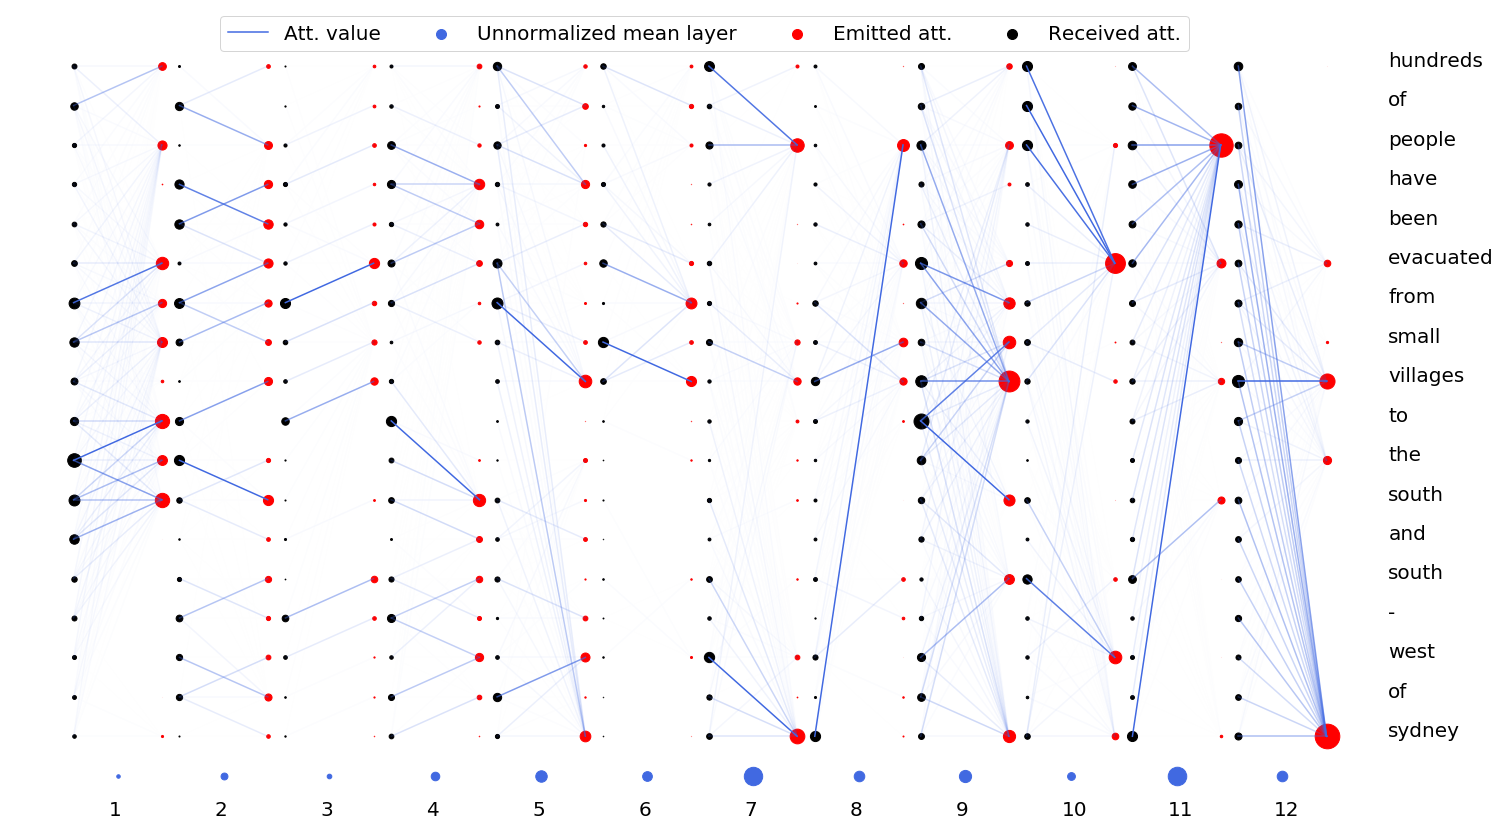

In [5]:
# Show visualization for attention in prune_sentence
viz.viz_text(prune_sentence, tokens, dot=False)